<div style="font-variant: small-caps; 
      font-weight: normal; 
      font-size: 37px; 
      text-align: center; 
      padding: 15px; 
      margin: 10px;">
  Machine Learning<br>
  </div> 

<div style="font-variant: small-caps; 
      font-weight: normal; 
      font-size: 35px; 
      text-align: center; 
      padding: 15px; 
      margin: 10px;">
  -<br>
  </div> 
  
<div style="font-variant: small-caps; 
      font-weight: normal; 
      font-size: 35px; 
      text-align: center; 
      padding: 15px; 
      margin: 10px;">
      Illustration with Random Forests<br><br>
  </div> 

<div style="font-variant: small-caps; 
      font-weight: normal; 
      font-size: 25px; 
      text-align: center; 
      padding: 15px; 
      margin: 10px;">
      <font color=orange> 3 - Regression</font>
  </div>

<div style="font-variant: small-caps; 
      font-weight: normal; 
      font-size: 20px; 
      text-align: center; 
      padding: 15px; 
      margin: 10px;">
      BSc - Fall 2024
  </div>

## Regression with Random Forests

-  [Regression Model scoring, underfitting, overfitting](#model_scoring)<br>
-  [Base model](#model_base)<br>
-  [Decision Tree Regressor](#decision_tree)<br>
-  [Tree bagging](#tree_bagging)<br>
-  [OOB score](#oob_score)<br>
-  [Stoping criteria](#tree_pruning)<br>
-  [Data subsampling](#data_sampling)<br>
-  [Feature subsampling](#feature_sampling)<br>
-  [Bagging as general Ensemble method](#general_bagging)<br>
-  [Cross validation](#cross_validation)<br>
-  [Hyperparameter tuning for final model selection](#hyperparameter_tuning)<br>


### Imports

In [1]:
# for package auto reload
%load_ext autoreload
%autoreload 2

# for better rendering of plots in jupyter notebook
%matplotlib inline

In [2]:
# base modules
import os
import sys
import copy
import logging
from collections import OrderedDict

# for manipulating data
import numpy as np
import pandas as pd
import math
import dill

# for Machine Learning
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.inspection import permutation_importance
from scipy.cluster import hierarchy

# for visualization
from IPython.display import display
from matplotlib import pyplot as plt
# plotly
# seaborn
# altair

In [3]:
# path to repo
path_to_repo = os.path.dirname(os.getcwd())
path_to_repo

'/Users/jiaokan/Workshop/Machine Learning in Practice'

In [4]:
sys.path.insert(0, os.path.join(path_to_repo, 'src'))

In [5]:
# custom module
from mlpcourse.utils import *

In [6]:
path_to_bulldozers = os.path.join(
    path_to_repo, "data", "bulldozers", "bulldozers-raw")
path_to_bulldozers

'/Users/jiaokan/Workshop/Machine Learning in Practice/data/bulldozers/bulldozers-raw'

# Regression with Random Forests

[Back to top](#plan)

<a id='model_scoring'></a>

### $\bullet$ Regression Model scoring, underfitting, overfitting

[Back to top](#plan)

In [7]:
# define the path to dataset
path_to_dataset = os.path.join(
    path_to_repo, "data", 'bulldozers', 'bulldozers-raw')
print(path_to_dataset)

# import raw data
df_raw = pd.read_feather(path_to_dataset)

# preprocess data
df, y, nas = proc_df(df_raw, 'SalePrice')

/Users/jiaokan/Workshop/Machine Learning in Practice/data/bulldozers/bulldozers-raw


In [8]:
print(df.shape)
df.head()

(401125, 66)


,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na
0,1139246,999089,3157,121,3.0,2004,68.0,1,950,296,...,320,False,False,False,False,False,False,1163635200,False,False
1,1139248,117657,77,121,3.0,1996,4640.0,1,1725,527,...,86,False,False,False,False,False,False,1080259200,False,False
2,1139249,434808,7009,121,3.0,2001,2838.0,3,331,110,...,57,False,False,False,False,False,False,1077753600,False,False
3,1139251,1026470,332,121,3.0,2001,3486.0,3,3674,1375,...,139,False,False,False,False,False,False,1305763200,False,False
4,1139253,1057373,17311,121,3.0,2007,722.0,2,4208,1529,...,204,False,False,False,False,False,False,1248307200,False,False


In [9]:
len(y)
y

array([11.09741002, 10.95080655,  9.21034037, ...,  9.35010231,
        9.10497986,  8.95544812])

In [10]:
model = RandomForestRegressor(n_estimators = 10, n_jobs = -1, random_state = 42)

%time model.fit(df, y)

CPU times: user 56.5 s, sys: 470 ms, total: 57 s
Wall time: 11 s


RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=42)

In [11]:
x = df.iloc[0]
y_true = np.exp(y[0])
x, y_true

(SalesID                           1139246
 MachineID                          999089
 ModelID                              3157
 datasource                            121
 auctioneerID                          3.0
                                   ...    
 saleIs_year_end                     False
 saleIs_year_start                   False
 saleElapsed                    1163635200
 auctioneerID_na                     False
 MachineHoursCurrentMeter_na         False
 Name: 0, Length: 66, dtype: object,
 np.float64(65999.99999999996))

In [12]:
x = [x]                   # wrap the data point into a list
y_pred = model.predict(x)  # prediction, as list
y_pred = y_pred[0]        # take first element of predicted list
y_pred = np.exp(y_pred)   # exponentialize
y_pred

/Users/jiaokan/Workshop/Machine Learning in Practice/.venv/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


np.float64(63651.865435089654)

In [13]:
model.score(df, y)

0.9830045032428727

In statistics, the coefficient of determination, denoted R2 or r2 and pronounced "R squared", is the proportion of the variance in the dependent variable that is predictable from the independent variable(s). https://en.wikipedia.org/wiki/Coefficient_of_determination

Wow, an r^2 of 0.98 - that's great, right? Well, perhaps not...

Possibly **the most important idea** in machine learning is that of having separate training & validation data sets. As motivation, suppose you don't divide up your data, but instead use all of it.  And suppose you have lots of parameters:

<img src="img/underfitting_overfitting.png" alt="" style="width: 70%"/>
<center>
[Underfitting and Overfitting](https://datascience.stackexchange.com/questions/361/when-is-a-model-underfitted)
</center>

The error for the pictured data points is lowest for the model on the far right (the blue curve passes through the red points almost perfectly), yet it's not the best choice.  Why is that?  If you were to gather some new data points, they most likely would not be on that curve in the graph on the right, but would be closer to the curve in the middle graph.

This illustrates how using all our data can lead to **overfitting**. A validation set helps diagnose this problem.

In [14]:
def split_vals(df, n):
    return df[:n].copy(), df[n:].copy()

In [15]:
n_total = len(df)
n_valid = 12000  # same as Kaggle's test set size
n_train = n_total - n_valid
n_small = 20000

print('full number of data points : {}'.format(n_total))
print('number of validation data points : {}'.format(n_valid))
print('number of training data points : {}'.format(n_train))
print('number of subsampled training points : {}'.format(n_small))

full number of data points : 401125
number of validation data points : 12000
number of training data points : 389125
number of subsampled training points : 20000


In [16]:
X_train, X_valid = split_vals(df, n_train)
y_train, y_valid = split_vals(y, n_train)

X_small, _ = split_vals(X_train, n_small)
y_small, _ = split_vals(y_train, n_small)

print('Number of small training data points: X = {}, y = {}'.format(
    X_small.shape, y_small.shape))
print('Number of full training data points: X = {}, y = {}'.format(
    X_train.shape, y_train.shape))
print('Number of validation data points: X = {}, y = {}'.format(
    X_valid.shape, y_valid.shape))

Number of small training data points: X = (20000, 66), y = (20000,)
Number of full training data points: X = (389125, 66), y = (389125,)
Number of validation data points: X = (12000, 66), y = (12000,)


<a id='model_base'></a>

### $\bullet$ Base model

[Back to top](#plan)

Let's try our model again, this time with separate training and validation sets.

In [17]:
def rmse(y_gold, y_pred):
    return math.sqrt(((y_gold - y_pred)**2).mean())

In [18]:
def print_score(m, X_train, y_train, X_valid, y_valid):
    print('RMSE on train set: {:.4f}'.format(
        rmse(m.predict(X_train), y_train)))
    print('RMSE on valid set: {:.4f}'.format(
        rmse(m.predict(X_valid), y_valid)))
    print('R^2 on train set: {:.4f}'.format(m.score(X_train, y_train)))
    print('R^2 on valid set: {:.4f}'.format(m.score(X_valid, y_valid)))
    if hasattr(m, 'oob_score_'):
        print('R^2 on oob set: {:.4f}'.format(m.oob_score_))
    return

In [19]:
# model on small training data
base_model = RandomForestRegressor(n_estimators = 10, n_jobs = -1, random_state = 42)

%time base_model.fit(X_small, y_small)
print_score(base_model, X_small, y_small, X_valid, y_valid)

CPU times: user 2.22 s, sys: 15.1 ms, total: 2.23 s
Wall time: 441 ms
RMSE on train set: 0.1045
RMSE on valid set: 0.3394
R^2 on train set: 0.9779
R^2 on valid set: 0.7943


In [20]:
# model on full training data
base_model = RandomForestRegressor(n_estimators = 10, n_jobs = -1, random_state = 42)

%time base_model.fit(X_train, y_train)
print_score(base_model, X_train, y_train, X_valid, y_valid)

CPU times: user 54 s, sys: 416 ms, total: 54.4 s
Wall time: 10.6 s
RMSE on train set: 0.0906
RMSE on valid set: 0.2487
R^2 on train set: 0.9828
R^2 on valid set: 0.8896


An r^2 in the high-80's isn't bad at all (and the RMSLE puts us around rank 100 of 470 on the Kaggle leaderboard), but we can see from the validation set score that we're over-fitting badly. To understand this issue, let's simplify things down to a single small tree.

<a id="decision_tree"></a>

### $\bullet$ Decision Tree Regressor

[Back to top](#plan)


Let us describe the process of construction of a single decision tree, over a dataset $\mathcal{D}_1$ described by two explanatory variables $X_1$ and $X_2$ and an output variable $Y$ :<br>

| $X^1$ | $X^2$ | $Y$ |
|-----|-----|-----|
| $x^1_1$ | $x^2_1$ | $y_1$ |
| $x^1_2$ | $x^2_2$ | $y_2$ |
| $x^1_3$ | $x^2_3$ | $y_3$ |



#### 1. Splitting process

The decision tree will first split the dataset $\mathcal{D}_1$ into two sub-datasets $\mathcal{D}_2$ and $\mathcal{D}_3$, by choosing a variable among the explanatory variables (let's say $X^1$) and a separation threshold $d_1$ for this variable. The way of selecting a variable and a threshold is detailed in the *Splitting Strategy* paragraph below.<br> Such choice divides the dataset $\mathcal{D}_1$ into <br>

$$\mathcal{D}_2 = \displaystyle \lbrace  (x^1, x^2, y) \in \mathcal{D}_1 \, | \, x^1 \leqslant d_1 \rbrace \qquad \qquad \mathcal{D}_3 = \{ (x^1, x^2, y) \in \mathcal{D}_1 \, | \, x^1 > d_1 \}$$

<img src="img/decision_tree_1_.png" alt="" style="width: 50%"/>

If the tree construction would stop here, the resulting decision tree $\mathcal{T}$ is a prediction model that associates, to any new data point $(o^1, o^2)$, the value accoring to the following two cases : if $o^1 \leqslant d_1$, then $\mathcal{T}(o^1, o^2)$ is the average values of the output values among the $\mathcal{D}_2$ subset, whereas if $o^1 > d_1$, then $\mathcal{T}(o^1, o^2)$ is the average values of the output values among the $\mathcal{D}_3$ subset.<br>
This is more formally written as :

$$ \mathcal{T}(o^1, o^2) = 
\begin{cases}
\displaystyle \frac{1}{\vert \mathcal{D}_2 \vert } \sum _{(x^1, x^2, y) \, \in \, \mathcal{D}_2} y & \text{if } o^1 \leqslant d_1 \\
\displaystyle \frac{1}{\vert \mathcal{D}_3 \vert} \sum _{(x^1, x^2, y) \, \in \, \mathcal{D}_3} y & \text{if } o^1 > d_1\\
\end{cases}
$$


Actually the tree does not stop here in general, but implement subsequent splittings as detained in the *Recurrence process* paragraph below.


#### 2. Splitting Strategy

The splitting strategy depends on the choice of a measure of *Heterogeneity* of a set of output values. For decision tree regression, the heterogeneity of a set $Y = \{ y_1, y_2, y_3, ...\}$ of real values (i.e. floating numbers) is taken as its variance $Var(Y)$ :

$$ \overline{Y} = \frac{1}{\vert Y \vert}\displaystyle \sum _{y\, \in \, Y} y \qquad \qquad Var(Y) = \frac{1}{\vert Y \vert}\displaystyle \sum _{y\, \in \, Y} ( y - \overline{Y} ) ^2$$


It is a heterogeneity measure as the more the set $Y$ is concentrated around a single value (e.g. its average) then the less the variance is.<br>

Now that the homogeneity of a set has been defined, the splitting strategy consists in chosing, given a set of data $\mathcal{D}$, a variable $X^*$ among $X^1$ and $X^2$ as well as a threshold $d^*$ that minimizes, among the possible variables and thresholds, the summed heterogeneity



$$ \mathcal{D}_{left} = \lbrace (x^1, x^2, y) \in \mathcal{D}, \;  x^i \leqslant d \rbrace $$
$$ \mathcal{D}_{right} = \lbrace (x^1, x^2, y) \in \mathcal{D}, \;  x^i > d \rbrace $$

<br>
<br>

$$
H(\mathcal{D}, X^i, d) =  \vert \mathcal{D}_{left} \vert \times Var(\lbrace y \, | \, (x^1, x^2, y) \in \mathcal{D}_{left} \rbrace) \quad +  \quad \vert \mathcal{D}_{right} \vert \times Var(\lbrace y \, | \, (x^1, x^2, y) \in \mathcal{D}_{right} \rbrace)
$$


This quantity is the variance which is obtained by splitting the dataset along the $X^*$ variable about the threshold $d^*$, and the resulting best choice is the one that minimizes this variance.


#### 3. Recurrence process

The full decision tree is built by _iterating_ the splitting process : If the splitting strategy yields a first decision along a variable $X^1$ with threshold $d_1$, yielding two sub-datasets $\mathcal{D}_2$ and $\mathcal{D}_3$, then the same splitting strategy is performed on $\mathcal{D}_2$ and $\mathcal{D}_3$ independently. The process stops when the splitting strategy does not find any candidate variable and threshold over any of the sub-datasets obtained so far.<br>

As an illustration, let us suppose that, after the first splitting step descrived earlier, that the splitting strategy finds no splitting on $\mathcal{D}_3$ and a splitting of $\mathcal{D}_2$ according to the variable $X^2$ and threshold $d_2$, yielding 

$$\mathcal{D}_4 = \displaystyle \lbrace  (x^1, x^2, y) \in \mathcal{D}_2 \, | \, x^2 \leqslant d_2 \rbrace \qquad \qquad \mathcal{D}_5 = \{ (x^1, x^2, y) \in \mathcal{D}_2 \, | \, x^2 > d_2 \}$$

Suppose moreover that a third step yields a splitting of $\mathcal{D}_5$ according to the variable $X^1$ and threshold $d_3$, yielding 

$$\mathcal{D}_6 = \displaystyle \lbrace  (x^1, x^2, y) \in \mathcal{D}_5 \, | \, x^1 \leqslant d_3 \rbrace \qquad \qquad \mathcal{D}_7 = \{ (x^1, x^2, y) \in \mathcal{D}_5 \, | \, x^1 > d_3 \}$$

Then the resulting decision tree can be pictured as follows :

<img src="img/decision_tree_3.png" alt="" style="width: 50%"/>


The resulting prediction model $\mathcal{T}$ is then given by the following function on a new data point $(o^1, o^2)$ :

$$ \mathcal{T}(o^1, o^2) = 
\begin{cases}
\displaystyle \frac{1}{\vert \mathcal{D}_3 \vert} \sum _{(x^1, x^2, y) \, \in \, \mathcal{D}_3} y & \text{if } o^1 > d_1\\
\displaystyle \frac{1}{\vert \mathcal{D}_4 \vert} \sum _{(x^1, x^2, y) \, \in \, \mathcal{D}_4} y & \text{if } o^1 \leqslant d_1 \text{ and } o^2 \leqslant d_2 \\
\displaystyle \frac{1}{\vert \mathcal{D}_6 \vert} \sum _{(x^1, x^2, y) \, \in \, \mathcal{D}_6} y & \text{if } o^1 \leqslant d_1 \text{ and } o^2 > d_2 \text{ and } o^1 \leqslant d_3 \\
\displaystyle \frac{1}{\vert \mathcal{D}_7 \vert} \sum _{(x^1, x^2, y) \, \in \, \mathcal{D}_7} y & \text{if } o^1 \leqslant d_1 \text{ and } o^2 > d_2 \text{ and } o^1 > d_3 \\
\end{cases}
$$


#### Final remarks 

- A single splitting step consists in finding the best splits *for each subsample where splitting is possible*. 
- When looking at an optimal choice of splitting, *all variables are systematically used* even if they were selected in a revious splitting.
- The splitting of a subsample stops when it contains a single data point, or when a certain *stopping criterion has been reached*, which prevents any subsequent splitting.
- The final tree prediction values always belong to a finite set of possible values, one value per leaf, given as the averaged ouput of training data points belonging to the leaf.

**Option 1**: Using _sklearn.tree.DecisionTreeRegressor_

In [21]:
help(DecisionTreeRegressor)

Help on class DecisionTreeRegressor in module sklearn.tree._classes:

class DecisionTreeRegressor(sklearn.base.RegressorMixin, BaseDecisionTree)
 |  DecisionTreeRegressor(*, criterion='squared_error', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, ccp_alpha=0.0, monotonic_cst=None)
 |  
 |  A decision tree regressor.
 |  
 |  Read more in the :ref:`User Guide <tree>`.
 |  
 |  Parameters
 |  ----------
 |  criterion : {"squared_error", "friedman_mse", "absolute_error",             "poisson"}, default="squared_error"
 |      The function to measure the quality of a split. Supported criteria
 |      are "squared_error" for the mean squared error, which is equal to
 |      variance reduction as feature selection criterion and minimizes the L2
 |      loss using the mean of each terminal node, "friedman_mse", which uses
 |      mean squared error wi

In [22]:
model_dt = DecisionTreeRegressor(
    criterion='squared_error',
    splitter='best',
    max_depth=3,  # None
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    ccp_alpha=0.0,
    random_state=42,  # None,
)

In [23]:
%time model_dt.fit(X_small, y_small)

print_score(model_dt, X_small, y_small, X_valid, y_valid)

CPU times: user 53 ms, sys: 1.44 ms, total: 54.4 ms
Wall time: 54.2 ms
RMSE on train set: 0.4966
RMSE on valid set: 0.5247
R^2 on train set: 0.5015
R^2 on valid set: 0.5084


In [24]:
model_dt = DecisionTreeRegressor(
    criterion='squared_error',
    splitter='best',
    max_depth=15,  # None
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    ccp_alpha=0.0,
    random_state=42,  # None,
)

In [25]:
%time model_dt.fit(X_small, y_small)
print_score(model_dt, X_small, y_small, X_valid, y_valid)

CPU times: user 218 ms, sys: 1.65 ms, total: 219 ms
Wall time: 220 ms
RMSE on train set: 0.1488
RMSE on valid set: 0.4297
R^2 on train set: 0.9552
R^2 on valid set: 0.6702


In [26]:
model_dt = DecisionTreeRegressor(
    criterion='squared_error',
    splitter='best',
    max_depth=15,  # None
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0001,
    ccp_alpha=0.0,
    random_state=42,  # None,
)

In [27]:
%time model_dt.fit(X_small, y_small)
print_score(model_dt, X_small, y_small, X_valid, y_valid)

CPU times: user 164 ms, sys: 1.65 ms, total: 166 ms
Wall time: 166 ms
RMSE on train set: 0.2679
RMSE on valid set: 0.3565
R^2 on train set: 0.8549
R^2 on valid set: 0.7730


In [28]:
model_dt = DecisionTreeRegressor(
    criterion='squared_error',
    splitter='best',
    max_depth=3,  # None
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    ccp_alpha=0.0,
    random_state=42,  # None,
)

In [29]:
%time model_dt.fit(X_small, y_small)
print_score(model_dt, X_small, y_small, X_valid, y_valid)

CPU times: user 52.9 ms, sys: 1.35 ms, total: 54.2 ms
Wall time: 54.2 ms
RMSE on train set: 0.4966
RMSE on valid set: 0.5247
R^2 on train set: 0.5015
R^2 on valid set: 0.5084


[Text(0.5, 0.875, 'x[37] <= 0.5\nsquared_error = 0.495\nsamples = 20000\nvalue = 10.189'),
 Text(0.25, 0.625, 'x[19] <= 2.0\nsquared_error = 0.414\nsamples = 16815\nvalue = 10.345'),
 Text(0.375, 0.75, 'True  '),
 Text(0.125, 0.375, 'x[2] <= 4573.0\nsquared_error = 0.331\nsamples = 4400\nvalue = 9.955'),
 Text(0.0625, 0.125, 'squared_error = 0.315\nsamples = 2002\nvalue = 10.226'),
 Text(0.1875, 0.125, 'squared_error = 0.232\nsamples = 2398\nvalue = 9.728'),
 Text(0.375, 0.375, 'x[19] <= 4.5\nsquared_error = 0.37\nsamples = 12415\nvalue = 10.484'),
 Text(0.3125, 0.125, 'squared_error = 0.29\nsamples = 7193\nvalue = 10.736'),
 Text(0.4375, 0.125, 'squared_error = 0.272\nsamples = 5222\nvalue = 10.137'),
 Text(0.75, 0.625, 'x[5] <= 1999.5\nsquared_error = 0.109\nsamples = 3185\nvalue = 9.363'),
 Text(0.625, 0.75, '  False'),
 Text(0.625, 0.375, 'x[14] <= 40.5\nsquared_error = 0.101\nsamples = 468\nvalue = 8.988'),
 Text(0.5625, 0.125, 'squared_error = 0.069\nsamples = 293\nvalue = 8.896'

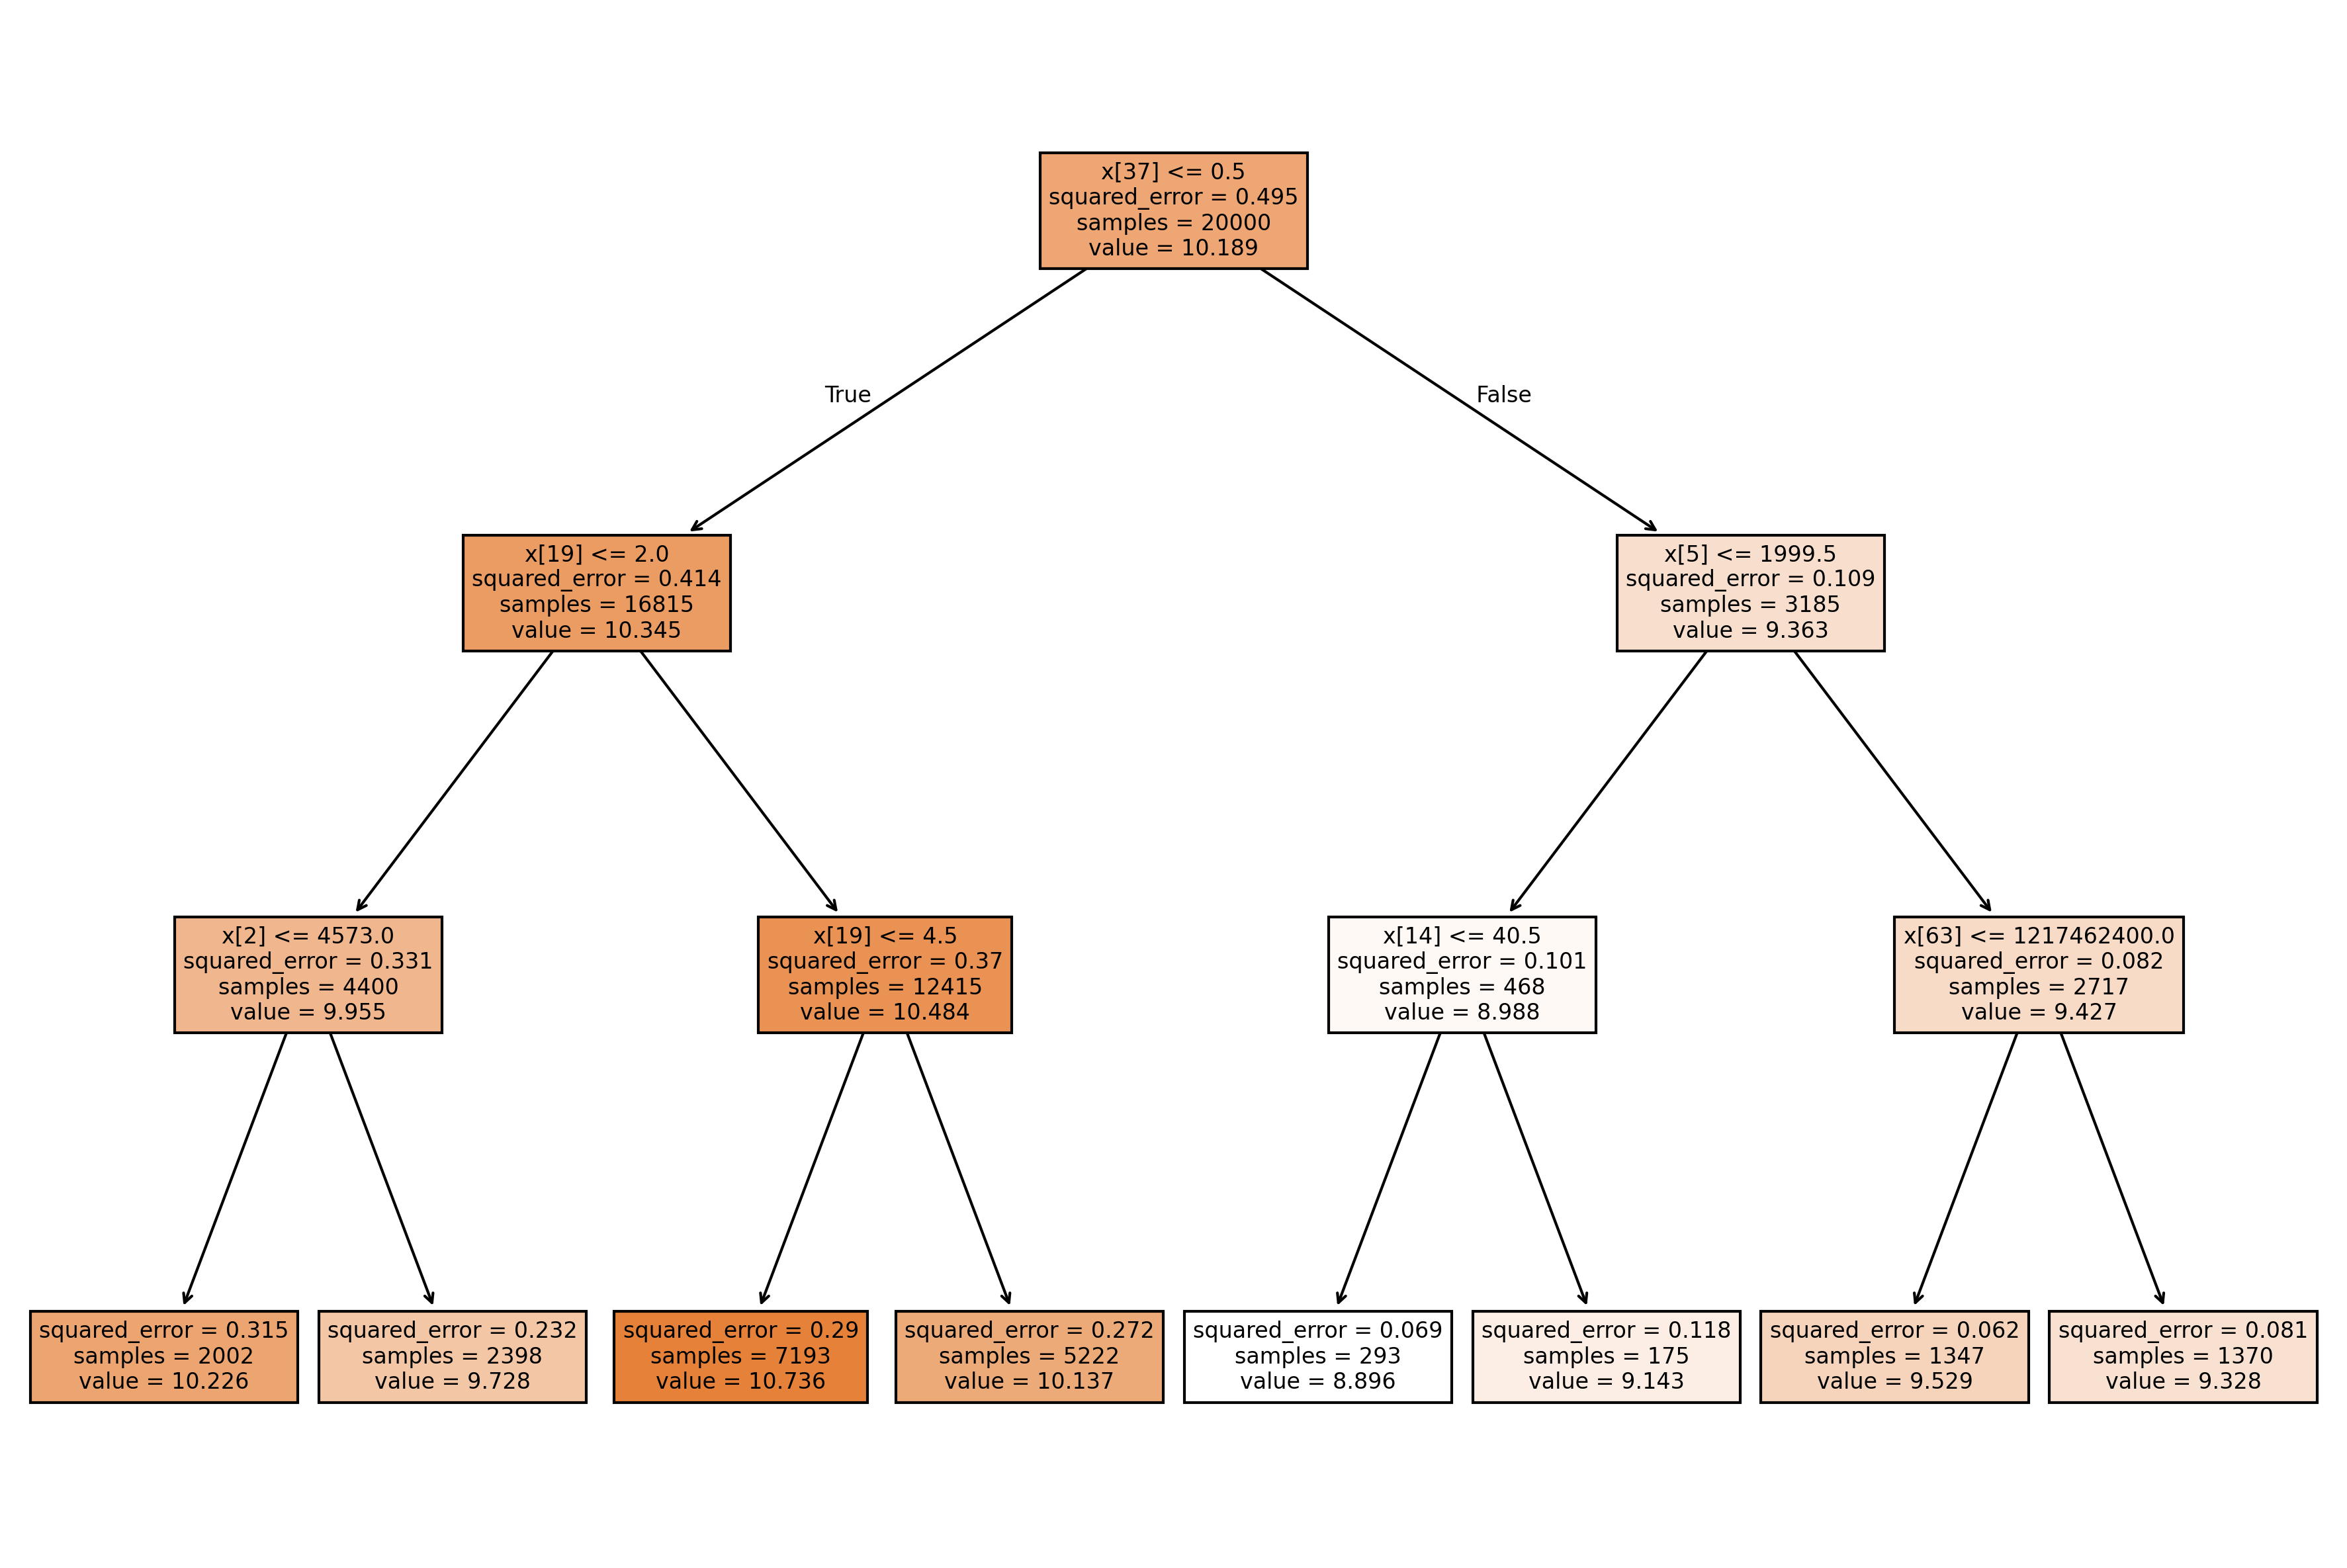

In [30]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 10), dpi=300)
plot_tree(model_dt, filled=True)

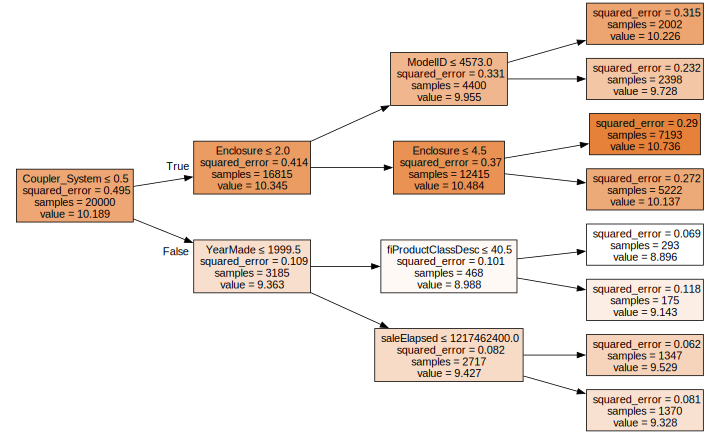

In [31]:
draw_tree(model_dt, X_small, precision=3)

**Option 2**: Using _sklearn.ensemble.RandomForestRegressor_

In [32]:
model_rf = RandomForestRegressor(
    # parameters shared with DecisionTreeRegressor
    n_estimators=1,  # 100 # 1 = the model is a single tree
    criterion='squared_error',
    max_depth=3,  # None
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    ccp_alpha=0.0,
    random_state=42,  # None,

    # RandomForestRegressor specific hyperparameters
    bootstrap=False,  # default = True
    oob_score=False,
    max_samples=None,

    # extra parameters
    warm_start=False,
    n_jobs=-1,  # None
    verbose=0,
)

In [33]:
%time model_rf.fit(X_small, y_small)
print_score(model_rf, X_small, y_small, X_valid, y_valid)

CPU times: user 55.1 ms, sys: 3.38 ms, total: 58.5 ms
Wall time: 64.6 ms
RMSE on train set: 0.4966
RMSE on valid set: 0.5247
R^2 on train set: 0.5015
R^2 on valid set: 0.5084


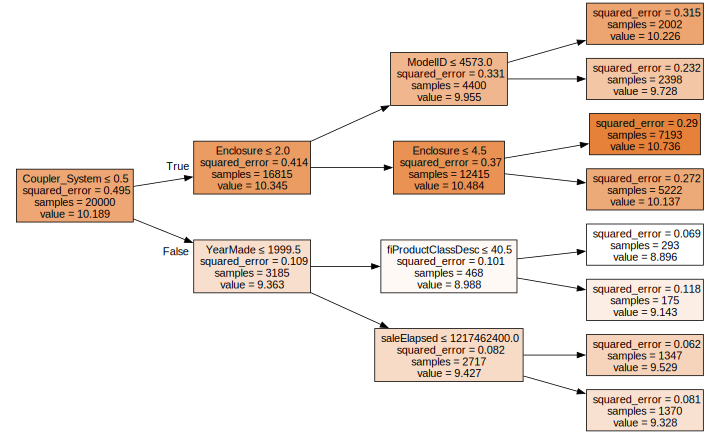

In [34]:
# first install graphviz source files, see:
# https://forum.graphviz.org/t/new-simplified-installation-procedure-on-windows/224#abbreviated-installation-instructions-recommended-for-users-with-installation-experience

draw_tree(model_rf.estimators_[0], X_small, precision=3)

Using a Random Forest with 2 trees :

In [35]:
model_rf = RandomForestRegressor(
    # parameters shared with DecisionTreeRegressor
    n_estimators=2,  # 100 # 1 = the model is a single tree
    criterion='squared_error',
    max_depth=3,  # None
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features=0.5,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    ccp_alpha=0.0,
    random_state=42,  # None,

    # RandomForestRegressor specific hyperparameters
    bootstrap=True,  # default = True
    oob_score=False,
    max_samples=0.5,

    # extra parameters
    warm_start=False,
    n_jobs=-1,  # None
    verbose=0,
)

In [36]:
%time model_rf.fit(X_small, y_small)
print_score(model_rf, X_small, y_small, X_valid, y_valid)

CPU times: user 25.4 ms, sys: 3.49 ms, total: 28.9 ms
Wall time: 17.7 ms
RMSE on train set: 0.4836
RMSE on valid set: 0.5393
R^2 on train set: 0.5272
R^2 on valid set: 0.4806


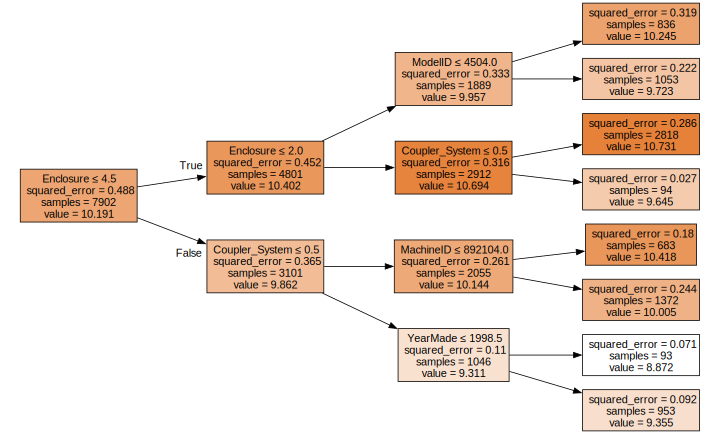

In [37]:
draw_tree(model_rf.estimators_[0], X_small, precision=3)

In [38]:
X_small.Enclosure

0        3
1        3
2        6
3        3
4        1
        ..
19995    3
19996    3
19997    3
19998    1
19999    3
Name: Enclosure, Length: 20000, dtype: int8

In [39]:
df_raw.Enclosure.tolist()[:10]

['EROPS w AC',
 'EROPS w AC',
 'OROPS',
 'EROPS w AC',
 'EROPS',
 'OROPS',
 'EROPS',
 'OROPS',
 'EROPS',
 'EROPS w AC']

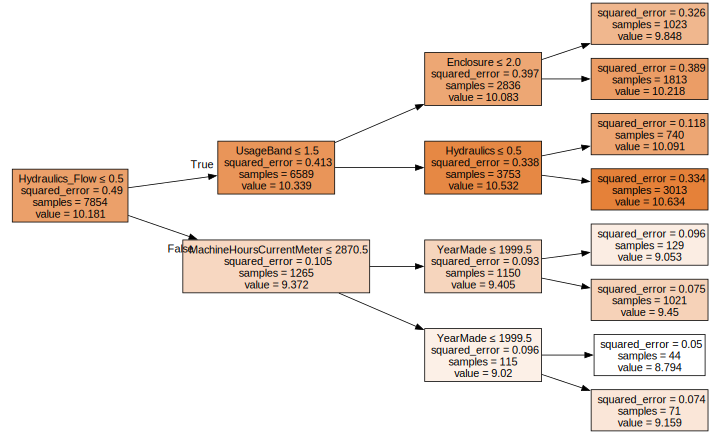

In [40]:
draw_tree(model_rf.estimators_[1], X_small, precision=3)

In [41]:
X_small.fiProductClassDesc

0        59
1        62
2        39
3         8
4        40
         ..
19995    67
19996    61
19997    27
19998    62
19999    35
Name: fiProductClassDesc, Length: 20000, dtype: int8

In [42]:
df_raw.fiProductClassDesc.tolist()[:50]

['Wheel Loader - 110.0 to 120.0 Horsepower',
 'Wheel Loader - 150.0 to 175.0 Horsepower',
 'Skid Steer Loader - 1351.0 to 1601.0 Lb Operating Capacity',
 'Hydraulic Excavator, Track - 12.0 to 14.0 Metric Tons',
 'Skid Steer Loader - 1601.0 to 1751.0 Lb Operating Capacity',
 'Backhoe Loader - 14.0 to 15.0 Ft Standard Digging Depth',
 'Hydraulic Excavator, Track - 21.0 to 24.0 Metric Tons',
 'Backhoe Loader - 14.0 to 15.0 Ft Standard Digging Depth',
 'Hydraulic Excavator, Track - 3.0 to 4.0 Metric Tons',
 'Wheel Loader - 350.0 to 500.0 Horsepower',
 'Backhoe Loader - 14.0 to 15.0 Ft Standard Digging Depth',
 'Track Type Tractor, Dozer - 20.0 to 75.0 Horsepower',
 'Hydraulic Excavator, Track - 19.0 to 21.0 Metric Tons',
 'Backhoe Loader - 14.0 to 15.0 Ft Standard Digging Depth',
 'Backhoe Loader - 14.0 to 15.0 Ft Standard Digging Depth',
 'Backhoe Loader - 14.0 to 15.0 Ft Standard Digging Depth',
 'Hydraulic Excavator, Track - 3.0 to 4.0 Metric Tons',
 'Hydraulic Excavator, Track - 4.0 to

Let's see what happens if we create a bigger tree.

In [43]:
model_dt = DecisionTreeRegressor(
    criterion='squared_error',  # 'mse',
    splitter='best',
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    random_state=42,  # None,
    ccp_alpha=0.0,
)

In [44]:
model_dt.fit(X_small, y_small)
print_score(model_dt, X_small, y_small, X_valid, y_valid)

RMSE on train set: 0.2755
RMSE on valid set: 0.3888
R^2 on train set: 0.8465
R^2 on valid set: 0.7300


Let us remove the constrain on the tree depth :

In [45]:
model_dt = DecisionTreeRegressor(
    criterion='squared_error',  # 'mse',
    splitter='best',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    random_state=42,  # None,
    ccp_alpha=0.0,
)

In [46]:
model_dt.fit(X_small, y_small)
print_score(model_dt, X_small, y_small, X_valid, y_valid)

RMSE on train set: 0.0000
RMSE on valid set: 0.4594
R^2 on train set: 1.0000
R^2 on valid set: 0.6230


<a id="tree_bagging"></a>

### $\bullet$ Tree bagging

[Back to top](#plan)

The training set result looks great! But the validation set is worse than our original model. This is why we need to use *bagging* of multiple trees to get more generalizable results. To learn about bagging in random forests, let's start with our basic model again.<br>

By the way, Bagging is the reduction of __B__oostrap **Agg**regation.

In [47]:
help(RandomForestRegressor)

Help on class RandomForestRegressor in module sklearn.ensemble._forest:

class RandomForestRegressor(ForestRegressor)
 |  RandomForestRegressor(n_estimators=100, *, criterion='squared_error', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=1.0, max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, ccp_alpha=0.0, max_samples=None, monotonic_cst=None)
 |  
 |  A random forest regressor.
 |  
 |  A random forest is a meta estimator that fits a number of decision tree
 |  regressors on various sub-samples of the dataset and uses averaging to
 |  improve the predictive accuracy and control over-fitting.
 |  Trees in the forest use the best split strategy, i.e. equivalent to passing
 |  `splitter="best"` to the underlying :class:`~sklearn.tree.DecisionTreeRegressor`.
 |  The sub-sample size is controlled with the `max_samples` parameter if
 |  `bootstrap

In [48]:
base_model = RandomForestRegressor(
    # parameters shared with DecisionTreeRegressor
    n_estimators = 10, # 100 # 1 = the model is a single tree
    criterion = 'squared_error', 
    max_depth = 10, # None
    min_samples_split = 2, 
    min_samples_leaf = 1,
    min_weight_fraction_leaf = 0.0,
    max_leaf_nodes = None, 
    min_impurity_decrease = 0.0,
    ccp_alpha = 0.0, 
    random_state = 42, # None, 
    
    # RandomForestRegressor specific hyperparameters
    bootstrap = True,
    oob_score = False, 
    max_samples = None,

    # extra parameters
    warm_start = False, 
    n_jobs = -1, # None 
    verbose = 0, 
)

%time base_model.fit(X_small, y_small)
print_score(base_model, X_small, y_small, X_valid, y_valid)

CPU times: user 1.26 s, sys: 11.6 ms, total: 1.27 s
Wall time: 259 ms
RMSE on train set: 0.2428
RMSE on valid set: 0.3426
R^2 on train set: 0.8809
R^2 on valid set: 0.7903


In [49]:
point = X_valid.iloc[0, :]
print(point)

price = y_valid[0]
print(price, np.exp(price))

SalesID                           4364751
MachineID                         2300944
ModelID                               665
datasource                            172
auctioneerID                          1.0
                                  ...    
saleIs_year_end                     False
saleIs_year_start                   False
saleElapsed                    1284595200
auctioneerID_na                     False
MachineHoursCurrentMeter_na         False
Name: 389125, Length: 66, dtype: object
9.104979856318357 9000.000000000004


In [50]:
# the model makes prediction with model.predict method
# base_model.predict

# predict takes a list as input, so we turn our single point as a list (with a single element)
base_model.predict([point])

# the model returns a list, so we take the first element, and apply exponetial
np.exp(base_model.predict([point])[0])

/Users/jiaokan/Workshop/Machine Learning in Practice/.venv/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/jiaokan/Workshop/Machine Learning in Practice/.venv/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


np.float64(12093.097759068927)

We'll grab the predictions for each individual tree, and look at one example.

In [51]:
# model prediction on single data point
trees = base_model
point = [X_valid.iloc[0, :]]
pred = trees.predict(point)

print('Type:', type(pred))
print('Shape:', pred.shape)
print('Value:', np.exp(pred[0]))

Type: <class 'numpy.ndarray'>
Shape: (1,)
Value: 12093.097759068927


/Users/jiaokan/Workshop/Machine Learning in Practice/.venv/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [52]:
# first tree prediction on single data point
# chose between 0 and 9 since we have 10 estimators
tree = base_model.estimators_[0]
# tree.predict takes an iterable of data points as input
point = [X_valid.iloc[0, :]]
# tree.predict returns a numpy tensor of predictions as output
pred = tree.predict(point)

print('Type:', type(pred))
print('Shape:', pred.shape)
print('Value:', np.exp(pred[0]))

Type: <class 'numpy.ndarray'>
Shape: (1,)
Value: 9556.50275789247


In [53]:
# first tree prediction on single data point
# chose between 0 and 9 since we have 10 estimators
tree = base_model.estimators_[1]
# tree.predict takes an iterable of data points as input
point = [X_valid.iloc[0, :]]
# tree.predict returns a numpy tensor of predictions as output
pred = tree.predict(point)

print('Type:', type(pred))
print('Shape:', pred.shape)
print('Value:', np.exp(pred[0]))

Type: <class 'numpy.ndarray'>
Shape: (1,)
Value: 19191.719017642925


In [54]:
# all tree predictions on single data point
trees = base_model.estimators_
point = [X_valid.iloc[0, :]]
preds = np.asarray([tree.predict(point) for tree in trees])

print('Type:', type(preds))
print('Shape:', preds.shape)
print('Value:', np.exp(preds))

Type: <class 'numpy.ndarray'>
Shape: (10, 1)
Value: [[ 9556.50275789]
 [19191.71901764]
 [ 9154.23475433]
 [15400.14953744]
 [10922.50433763]
 [14819.09564635]
 [11250.        ]
 [13025.60077779]
 [10954.4511501 ]
 [ 9957.05604281]]


In [55]:
# all tree predictions on all data
preds = np.stack([tree.predict(X_valid)
                 for tree in base_model.estimators_])  # or np.asarray()

# predictions of the 10 trees, mean, and actual value (for first point in validation set)
preds[:, 0], base_model.predict(point)[0], np.mean(preds[:, 0]), y_valid[0]

/Users/jiaokan/Workshop/Machine Learning in Practice/.venv/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/jiaokan/Workshop/Machine Learning in Practice/.venv/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/jiaokan/Workshop/Machine Learning in Practice/.venv/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/jiaokan/Workshop/Machine Learning in Practice/.venv/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/jiaokan/Workshop/Machine Learning in Practice/.venv/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X 

(array([9.16497712, 9.86223416, 9.12197187, 9.6421325 , 9.29858056,
        9.60367187, 9.32812341, 9.47467199, 9.30150115, 9.20603673]),
 np.float64(9.400390135691154),
 np.float64(9.400390135691156),
 np.float64(9.104979856318357))

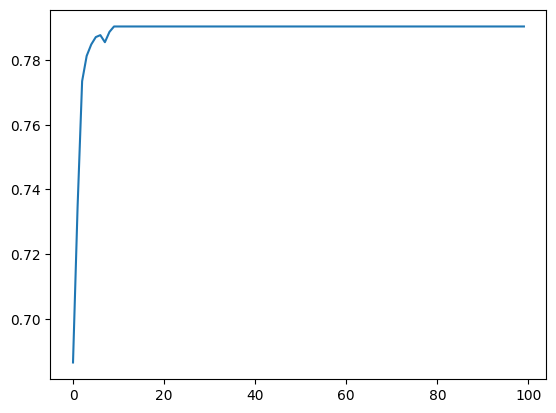

In [56]:
plt.plot([
    metrics.r2_score(y_valid, np.mean(preds[:num_trees], axis=0)) for num_trees in range(1, 101)
])

The shape of this curve suggests that adding more trees isn't going to help us much. Let's check. (Compare this to our original model on a sample)

In [57]:
model = RandomForestRegressor(
    # parameters shared with DecisionTreeRegressor
    n_estimators = 20, # 100 # 1 = the model is a single tree
    criterion = 'squared_error', 
    max_depth = 10, # None
    min_samples_split = 2, 
    min_samples_leaf = 1,
    min_weight_fraction_leaf = 0.0,
    max_leaf_nodes = None, 
    min_impurity_decrease = 0.0,
    ccp_alpha = 0.0, 
    random_state = 42, # None, 
    
    # RandomForestRegressor specific hyperparameters
    bootstrap = True,
    oob_score = False, 
    max_samples = None,

    # extra parameters
    warm_start = False, 
    n_jobs = -1, # None 
    verbose = 0, 
)

%time model.fit(X_small, y_small)
print_score(model, X_small, y_small, X_valid, y_valid)

CPU times: user 2.59 s, sys: 30.1 ms, total: 2.62 s
Wall time: 459 ms
RMSE on train set: 0.2391
RMSE on valid set: 0.3372
R^2 on train set: 0.8844
R^2 on valid set: 0.7969


/Users/jiaokan/Workshop/Machine Learning in Practice/.venv/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/jiaokan/Workshop/Machine Learning in Practice/.venv/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/jiaokan/Workshop/Machine Learning in Practice/.venv/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/jiaokan/Workshop/Machine Learning in Practice/.venv/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/jiaokan/Workshop/Machine Learning in Practice/.venv/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X 

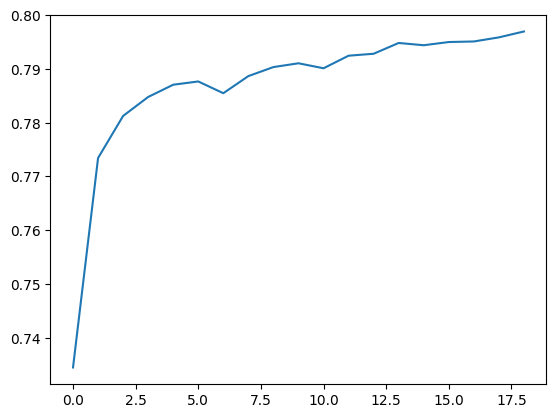

In [58]:
# all tree predictions on all data
preds = np.stack([tree.predict(X_valid)
                 for tree in model.estimators_])  # or np.asarray()

# predictions of the 10 trees, mean, and actual value (for first point in validation set)
preds.shape, preds[:, 0], np.mean(preds[:, 0]), y_valid[0]

plt.plot([
    metrics.r2_score(y_valid, np.mean(preds[:num_trees], axis=0))
    for num_trees in range(2, 21)
])

In [59]:
model = RandomForestRegressor(
    # parameters shared with DecisionTreeRegressor
    n_estimators = 30, # 100 # 1 = the model is a single tree
    criterion = 'squared_error', 
    max_depth = 10, # None
    min_samples_split = 2, 
    min_samples_leaf = 1,
    min_weight_fraction_leaf = 0.0,
    max_leaf_nodes = None, 
    min_impurity_decrease = 0.0,
    ccp_alpha = 0.0, 
    random_state = 42, # None, 
    
    # RandomForestRegressor specific hyperparameters
    bootstrap = True,
    oob_score = False, 
    max_samples = None,

    # extra parameters
    warm_start = False, 
    n_jobs = -1, # None 
    verbose = 0, 
)

%time model.fit(X_small, y_small)
print_score(model, X_small, y_small, X_valid, y_valid)

CPU times: user 3.92 s, sys: 28.4 ms, total: 3.95 s
Wall time: 593 ms
RMSE on train set: 0.2395
RMSE on valid set: 0.3349
R^2 on train set: 0.8841
R^2 on valid set: 0.7997


/Users/jiaokan/Workshop/Machine Learning in Practice/.venv/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/jiaokan/Workshop/Machine Learning in Practice/.venv/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/jiaokan/Workshop/Machine Learning in Practice/.venv/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/jiaokan/Workshop/Machine Learning in Practice/.venv/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/jiaokan/Workshop/Machine Learning in Practice/.venv/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X 

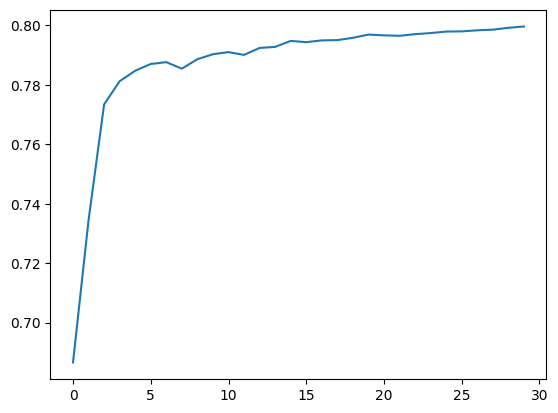

In [60]:
# all tree predictions on all data
preds = np.stack([tree.predict(X_valid)
                 for tree in model.estimators_])  # or np.asarray()

# predictions of the 10 trees, mean, and actual value (for first point in validation set)
preds.shape, preds[:, 0], np.mean(preds[:, 0]), y_valid[0]

plt.plot([
    metrics.r2_score(y_valid, np.mean(preds[:num_trees], axis=0))
    for num_trees in range(1, 31)
])

In [61]:
model = RandomForestRegressor(
    # parameters shared with DecisionTreeRegressor
    n_estimators = 50, # 100 # 1 = the model is a single tree
    criterion = 'squared_error', 
    max_depth = 10, # None
    min_samples_split = 2, 
    min_samples_leaf = 1,
    min_weight_fraction_leaf = 0.0, 
    
    max_leaf_nodes = None, 
    min_impurity_decrease = 0.0,
    ccp_alpha = 0.0, 
    random_state = 42, # None, 
    
    # RandomForestRegressor specific hyperparameters
    bootstrap = True,
    oob_score = False, 
    max_samples = None,

    # extra parameters
    warm_start = False, 
    n_jobs = -1, # None 
    verbose = 0, 
)

%time model.fit(X_small, y_small)
print_score(model, X_small, y_small, X_valid, y_valid)

CPU times: user 6.67 s, sys: 41.2 ms, total: 6.71 s
Wall time: 992 ms
RMSE on train set: 0.2380
RMSE on valid set: 0.3323
R^2 on train set: 0.8855
R^2 on valid set: 0.8028


/Users/jiaokan/Workshop/Machine Learning in Practice/.venv/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/jiaokan/Workshop/Machine Learning in Practice/.venv/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/jiaokan/Workshop/Machine Learning in Practice/.venv/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/jiaokan/Workshop/Machine Learning in Practice/.venv/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/jiaokan/Workshop/Machine Learning in Practice/.venv/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X 

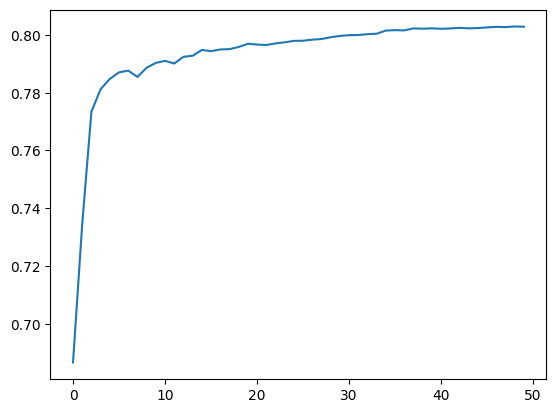

In [62]:
# all tree predictions on all data
preds = np.stack([tree.predict(X_valid)
                 for tree in model.estimators_])  # or np.asarray()

# predictions of the 10 trees, mean, and actual value (for first point in validation set)
preds.shape, preds[:, 0], np.mean(preds[:, 0]), y_valid[0]

plt.plot([
    metrics.r2_score(y_valid, np.mean(preds[:num_trees], axis=0))
    for num_trees in range(1, 51)
])

Let us try this time on the full training set :

In [63]:
model = RandomForestRegressor(
    # parameters shared with DecisionTreeRegressor
    n_estimators = 50, # 100 # 1 = the model is a single tree
    criterion = 'squared_error', 
    max_depth = 10, # None
    min_samples_split = 2, 
    min_samples_leaf = 1,
    min_weight_fraction_leaf = 0.0, 
    
    max_leaf_nodes = None, 
    min_impurity_decrease = 0.0,
    ccp_alpha = 0.0, 
    random_state = 42, # None, 
    
    # RandomForestRegressor specific hyperparameters
    bootstrap = True,
    oob_score = False, 
    max_samples = None,

    # extra parameters
    warm_start = False, 
    n_jobs = -1, # None 
    verbose = 0, 
)

%time model.fit(X_train, y_train)
print_score(model, X_train, y_train, X_valid, y_valid)

CPU times: user 2min 23s, sys: 1.02 s, total: 2min 24s
Wall time: 22 s
RMSE on train set: 0.2972
RMSE on valid set: 0.3099
R^2 on train set: 0.8154
R^2 on valid set: 0.8285


/Users/jiaokan/Workshop/Machine Learning in Practice/.venv/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/jiaokan/Workshop/Machine Learning in Practice/.venv/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/jiaokan/Workshop/Machine Learning in Practice/.venv/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/jiaokan/Workshop/Machine Learning in Practice/.venv/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/jiaokan/Workshop/Machine Learning in Practice/.venv/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X 

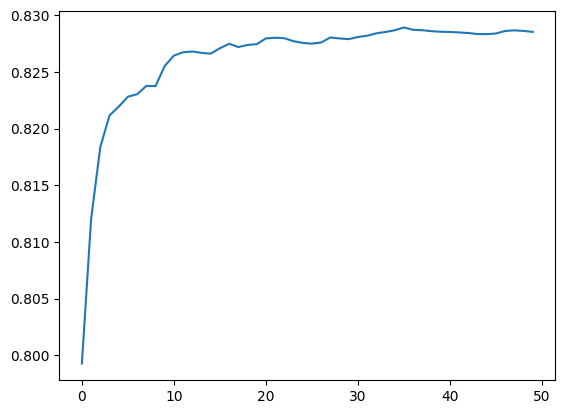

In [64]:
# all tree predictions on all data
preds = np.stack([tree.predict(X_valid)
                 for tree in model.estimators_])  # or np.asarray()

# predictions of the 10 trees, mean, and actual value (for first point in validation set)
preds.shape, preds[:, 0], np.mean(preds[:, 0]), y_valid[0]

plt.plot([
    metrics.r2_score(y_valid, np.mean(preds[:num_trees], axis=0))
    for num_trees in range(1, 51)
])

<a id='oob_score'></a>

### $\bullet$ Out-of-bag (OOB) score

[Back to top](#plan)

Is our validation set worse than our training set because we're over-fitting, or because the validation set is for a different time period, or a bit of both? With the existing information we've shown, we can't tell. However, random forests have a very clever trick called *out-of-bag (OOB) error* which can handle this (and more!)

The idea is to calculate error on the training set, but only include the trees in the calculation of a row's error where that row was *not* included in training that tree. This allows us to see whether the model is over-fitting, without needing a separate validation set.

This also has the benefit of allowing us to see whether our model generalizes, even if we only have a small amount of data so want to avoid separating some out to create a validation set.

This is as simple as adding one more parameter to our model constructor. We print the OOB error last in our `print_score` function below.

In [65]:
model = RandomForestRegressor(
    n_estimators = 40, 
    n_jobs = -1, 
    random_state = 42,
    
    bootstrap = True,
    oob_score = True, # default = False, 
    max_samples = None,
)

%time model.fit(X_small, y_small)
print_score(model, X_small, y_small, X_valid, y_valid)

CPU times: user 9.41 s, sys: 186 ms, total: 9.59 s
Wall time: 1.82 s
RMSE on train set: 0.0896
RMSE on valid set: 0.3239
R^2 on train set: 0.9838
R^2 on valid set: 0.8127
R^2 on oob set: 0.8828


Bagging trick :

| -| Tree 1  | Tree 2 |
|-----|-----|-----|
|Data 1 | (2 times) | - |
|Data 2  | (1 time) |(2 times) |
|Data 3 | - |(1 time) |

$$
R^2 \text{ on train set } > R^2 \text{ on oob set } \implies \text{ The model is overfitting} \\ 
R^2 \text{ on oob set } > R^2 \text{ on valid set } \implies \text{ Training / Validation sets carry differences} \\
$$

In [66]:
model = RandomForestRegressor(
    n_estimators = 40, 
    n_jobs = -1, 
    random_state = 42,
    
    bootstrap = True,
    oob_score = True, # default = False, 
    max_samples = None,
)

%time model.fit(X_train, y_train)
print_score(model, X_train, y_train, X_valid, y_valid)

CPU times: user 4min 3s, sys: 2.23 s, total: 4min 6s
Wall time: 36.8 s
RMSE on train set: 0.0785
RMSE on valid set: 0.2363
R^2 on train set: 0.9871
R^2 on valid set: 0.9003
R^2 on oob set: 0.9084


<a id='tree_pruning'></a>

### $\bullet$ Stoping criteria

[Back to top](#plan)

A way to reduce over-fitting is to grow our trees less deeply. We do this by specifying (with `min_samples_leaf` and `min_samples_split`) that we require some minimum number of rows in every leaf node. This has two benefits:

- There are less decision rules for each leaf node; simpler models should generalize better
- The predictions are made by averaging more rows in the leaf node, resulting in less volatility

In [67]:
def decision_tree_max_depth(tree):
    children_left = tree.children_left
    children_right = tree.children_right

    def walk(node_id):
        if (children_left[node_id] != children_right[node_id]):
            left_max = 1 + walk(children_left[node_id])
            right_max = 1 + walk(children_right[node_id])
            return max(left_max, right_max)
        else:  # leaf
            return 1

    root_node_id = 0
    return walk(root_node_id)

Baseline model

In [68]:
model = RandomForestRegressor(
    n_estimators = 40, 
    criterion = 'squared_error', 
    
    # stoping criteria
    max_depth = None,
    min_samples_split = 2, 
    min_samples_leaf = 1,
    min_weight_fraction_leaf = 0.0, 
    max_leaf_nodes = None, 
    min_impurity_decrease = 0.0, 
    ccp_alpha = 0.0, 
 
    # bagging parameters
    
    bootstrap = True,
    oob_score = True, 
    max_samples = None,
    
    # other
    warm_start = False, 
    n_jobs = -1, # None 
    random_state = 42, # None,
    verbose = 0, 
)

%time model.fit(X_small, y_small)
print_score(model, X_small, y_small, X_valid, y_valid)

CPU times: user 9.9 s, sys: 79.6 ms, total: 9.98 s
Wall time: 1.63 s
RMSE on train set: 0.0896
RMSE on valid set: 0.3239
R^2 on train set: 0.9838
R^2 on valid set: 0.8127
R^2 on oob set: 0.8828


In [69]:
tree = model.estimators_[0].tree_

decision_tree_max_depth(tree)

35

In [70]:
for i, tree in enumerate(model.estimators_):
    print('tree {} has depth {}'.format(i, decision_tree_max_depth(tree.tree_)))

tree 0 has depth 35
tree 1 has depth 36
tree 2 has depth 33
tree 3 has depth 33
tree 4 has depth 34
tree 5 has depth 34
tree 6 has depth 34
tree 7 has depth 33
tree 8 has depth 34
tree 9 has depth 33
tree 10 has depth 33
tree 11 has depth 32
tree 12 has depth 33
tree 13 has depth 34
tree 14 has depth 33
tree 15 has depth 34
tree 16 has depth 32
tree 17 has depth 34
tree 18 has depth 36
tree 19 has depth 33
tree 20 has depth 33
tree 21 has depth 34
tree 22 has depth 33
tree 23 has depth 33
tree 24 has depth 36
tree 25 has depth 32
tree 26 has depth 36
tree 27 has depth 34
tree 28 has depth 32
tree 29 has depth 35
tree 30 has depth 31
tree 31 has depth 36
tree 32 has depth 36
tree 33 has depth 33
tree 34 has depth 35
tree 35 has depth 33
tree 36 has depth 31
tree 37 has depth 36
tree 38 has depth 36
tree 39 has depth 34


In [71]:
model = RandomForestRegressor(
    n_estimators = 40, 
    min_samples_split = 15,
    min_samples_leaf = 15,
    n_jobs = -1, 
    random_state = 42,
    
    bootstrap = True,
    oob_score = True, # default = False, 
    max_samples = None,
)

%time model.fit(X_small, y_small)
print_score(model, X_small, y_small, X_valid, y_valid)

CPU times: user 6.18 s, sys: 47.4 ms, total: 6.22 s
Wall time: 953 ms
RMSE on train set: 0.2201
RMSE on valid set: 0.3288
R^2 on train set: 0.9021
R^2 on valid set: 0.8069
R^2 on oob set: 0.8640


In [72]:
tree = model.estimators_[0].tree_

decision_tree_max_depth(tree)

21

In [73]:
for i, tree in enumerate(model.estimators_):
    print('tree {} has depth {}'.format(i, decision_tree_max_depth(tree.tree_)))

tree 0 has depth 21
tree 1 has depth 21
tree 2 has depth 22
tree 3 has depth 19
tree 4 has depth 19
tree 5 has depth 21
tree 6 has depth 22
tree 7 has depth 20
tree 8 has depth 20
tree 9 has depth 20
tree 10 has depth 21
tree 11 has depth 21
tree 12 has depth 19
tree 13 has depth 23
tree 14 has depth 20
tree 15 has depth 19
tree 16 has depth 19
tree 17 has depth 19
tree 18 has depth 21
tree 19 has depth 22
tree 20 has depth 21
tree 21 has depth 22
tree 22 has depth 22
tree 23 has depth 20
tree 24 has depth 20
tree 25 has depth 21
tree 26 has depth 23
tree 27 has depth 19
tree 28 has depth 20
tree 29 has depth 23
tree 30 has depth 20
tree 31 has depth 22
tree 32 has depth 21
tree 33 has depth 20
tree 34 has depth 20
tree 35 has depth 21
tree 36 has depth 19
tree 37 has depth 21
tree 38 has depth 21
tree 39 has depth 21


<a id='data_sampling'></a>

### $\bullet$ Data subsampling

[Back to top](#plan)

It turns out that one of the easiest ways to avoid over-fitting is also one of the best ways to speed up analysis: *subsampling*.<br>

**Let's return to using our full dataset**, so that we can demonstrate the impact of this technique.<br>

The basic idea is this: rather than limit the total amount of data that our model can access, let's instead limit it to a *different* random subset per tree. That way, given enough trees, the model can still see *all* the data, but for each individual tree it'll be just as fast as if we had cut down our dataset as before.

In [74]:
model = RandomForestRegressor(
    n_estimators = 40,
    n_jobs = -1, 
    random_state = 42,
    
    bootstrap = True,
    oob_score = True, # default = False, 
    max_samples = None,
)

%time model.fit(X_train, y_train)
print_score(model, X_train, y_train, X_valid, y_valid)

CPU times: user 4min 33s, sys: 2.27 s, total: 4min 35s
Wall time: 42.5 s
RMSE on train set: 0.0785
RMSE on valid set: 0.2363
R^2 on train set: 0.9871
R^2 on valid set: 0.9003
R^2 on oob set: 0.9084


In [75]:
model = RandomForestRegressor(
    n_estimators = 40,
    n_jobs = -1, 
    random_state = 42,
    
    bootstrap = True,
    oob_score = True, # default = False, 
    max_samples = 0.15, # default = None,
)

%time model.fit(X_train, y_train)
print_score(model, X_train, y_train, X_valid, y_valid)

CPU times: user 58.4 s, sys: 705 ms, total: 59.1 s
Wall time: 10.7 s
RMSE on train set: 0.1910
RMSE on valid set: 0.2466
R^2 on train set: 0.9237
R^2 on valid set: 0.8914
R^2 on oob set: 0.8975


In [76]:
model = RandomForestRegressor(
    n_estimators = 200,
    n_jobs = -1, 
    random_state = 42,
    
    bootstrap = True,
    oob_score = True, # default = False, 
    max_samples = 0.15, # default = None,
)

%time model.fit(X_train, y_train)
print_score(model, X_train, y_train, X_valid, y_valid)

CPU times: user 4min 58s, sys: 4.11 s, total: 5min 2s
Wall time: 54.6 s
RMSE on train set: 0.1876
RMSE on valid set: 0.2427
R^2 on train set: 0.9265
R^2 on valid set: 0.8948
R^2 on oob set: 0.9008


In [77]:
model = RandomForestRegressor(
    n_estimators = 40, 
    criterion = 'squared_error', 
    
    # stoping criteria
    max_depth = 15,
    min_samples_split = 2, 
    min_samples_leaf = 1,
    min_weight_fraction_leaf = 0.0, 
    max_leaf_nodes = None, 
    min_impurity_decrease = 0.0, 
    ccp_alpha = 0.0, 
 
    # bagging parameters
    
    bootstrap = True,
    oob_score = True, 
    max_samples = 0.5,
    
    # other
    warm_start = False, 
    n_jobs = -1, # None 
    random_state = 42, # None,
    verbose = 0, 
)

%time model.fit(X_small, y_small)
print_score(model, X_small, y_small, X_valid, y_valid)

CPU times: user 5.33 s, sys: 69.3 ms, total: 5.4 s
Wall time: 901 ms
RMSE on train set: 0.1662
RMSE on valid set: 0.3239
R^2 on train set: 0.9442
R^2 on valid set: 0.8126
R^2 on oob set: 0.8788


<a id='feature_sampling'></a>

### $\bullet$ Feature subsampling

[Back to top](#plan)

We can also increase the amount of variation amongst the trees by not only use a sample of rows for each tree, but to also using a sample of *columns* for each *split*. We do this by specifying `max_features`, which is the proportion of features to randomly select from at each split.

- None
- 0.5
- 'sqrt'

In [78]:
model = RandomForestRegressor(
    n_estimators = 40,
    #max_features = 0.5, # default = 'auto'/None
    n_jobs = -1, 
    random_state = 42,
    
    bootstrap = True,
    oob_score = True, # default = False, 
    max_samples = None,
)

%time model.fit(X_small, y_small)
print_score(model, X_small, y_small, X_valid, y_valid)

CPU times: user 11.1 s, sys: 93.5 ms, total: 11.2 s
Wall time: 1.84 s
RMSE on train set: 0.0896
RMSE on valid set: 0.3239
R^2 on train set: 0.9838
R^2 on valid set: 0.8127
R^2 on oob set: 0.8828


In [79]:
model = RandomForestRegressor(
    n_estimators = 40,
    max_features = 0.5, # default = 'auto'/None
    n_jobs = -1, 
    random_state = 42,
    
    bootstrap = True,
    oob_score = True, # default = False, 
    max_samples = None,
)

%time model.fit(X_small, y_small)
print_score(model, X_small, y_small, X_valid, y_valid)

CPU times: user 5.49 s, sys: 59.8 ms, total: 5.55 s
Wall time: 904 ms
RMSE on train set: 0.0868
RMSE on valid set: 0.3248
R^2 on train set: 0.9848
R^2 on valid set: 0.8116
R^2 on oob set: 0.8899


In [80]:
model = RandomForestRegressor(
    n_estimators = 40,
    max_features = 0.5, # default = 'auto'/None
    n_jobs = -1, 
    random_state = 42,
    
    bootstrap = True,
    oob_score = True, # default = False, 
    max_samples = None,
)

%time model.fit(X_train, y_train)
print_score(model, X_train, y_train, X_valid, y_valid)

CPU times: user 2min 18s, sys: 1.68 s, total: 2min 20s
Wall time: 22.5 s
RMSE on train set: 0.0770
RMSE on valid set: 0.2285
R^2 on train set: 0.9876
R^2 on valid set: 0.9068
R^2 on oob set: 0.9118


Let us plot the oob error as a function of the number of trees, for some feature sampling euristics (see [sklearn documentation](http://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html))

<img src="img/oob_error_rates.png" alt="" style="width: 100%"/>

/Users/jiaokan/Workshop/Machine Learning in Practice/.venv/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/jiaokan/Workshop/Machine Learning in Practice/.venv/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/jiaokan/Workshop/Machine Learning in Practice/.venv/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/jiaokan/Workshop/Machine Learning in Practice/.venv/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to 

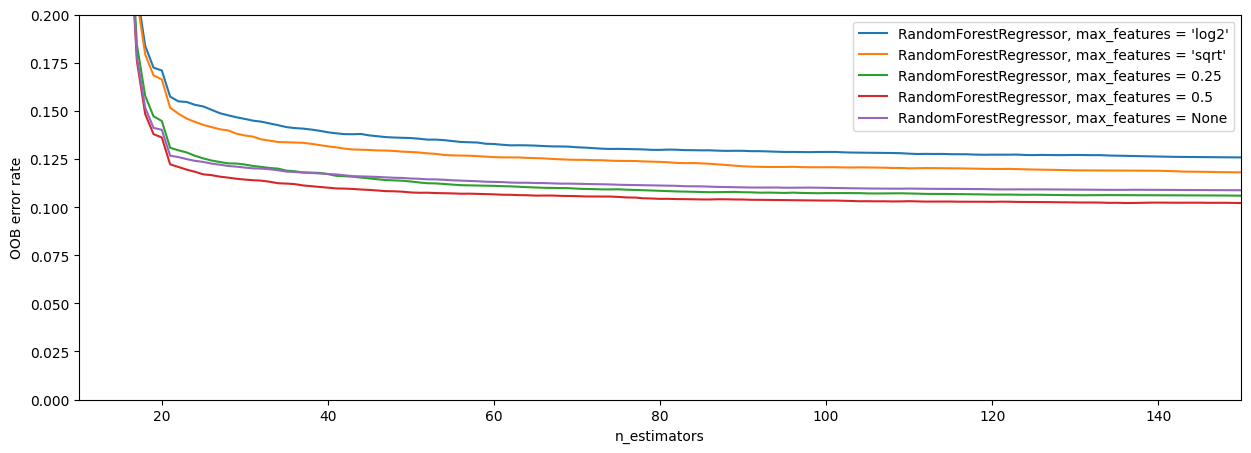

In [81]:
logging.info('warn')

# NOTE: Setting the `warm_start` construction parameter to `True` disables
# support for parallelized ensembles but is necessary for tracking the OOB
# error trajectory during training.
ensemble_clfs = [
    ("RandomForestRegressor, max_features = 'log2'",
        RandomForestRegressor(
            warm_start=True,
            oob_score=True,
            max_features="log2",
            random_state=42)),
    ("RandomForestRegressor, max_features = 'sqrt'",
        RandomForestRegressor(
            warm_start=True,
            oob_score=True,
            max_features="sqrt",
            random_state=42)),
    ("RandomForestRegressor, max_features = 0.25",
        RandomForestRegressor(
            warm_start=True,
            oob_score=True,
            max_features=0.25,
            random_state=42)),
    ("RandomForestRegressor, max_features = 0.5",
        RandomForestRegressor(
            warm_start=True,
            oob_score=True,
            max_features=0.5,
            random_state=42)),
    ("RandomForestRegressor, max_features = None",
        RandomForestRegressor(
            warm_start=True,
            oob_score=True,
            max_features=None,
            random_state=42)),
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 10
max_estimators = 150

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(X_small, y_small)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
plt.figure(figsize=(15, 5))
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

# Show the plot
plt.xlim(min_estimators, max_estimators)
plt.ylim(0., 0.2)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

In [82]:
model = RandomForestRegressor(
    n_estimators = 40, 
    criterion = 'squared_error', 
    
    # stoping criteria
    max_depth = 15,
    min_samples_split = 2, 
    min_samples_leaf = 1,
    min_weight_fraction_leaf = 0.0, 
    max_leaf_nodes = None, 
    min_impurity_decrease = 0.0, 
    ccp_alpha = 0.0, 
 
    # bagging parameters
    
    bootstrap = True,
    oob_score = True, 
    max_samples = None,
    
    # other
    warm_start = False, 
    n_jobs = -1, # None 
    random_state = 42, # None,
    verbose = 0, 
)

%time model.fit(X_train, y_train)
print_score(model, X_train, y_train, X_valid, y_valid)

CPU times: user 2min 47s, sys: 1.32 s, total: 2min 48s
Wall time: 25.3 s
RMSE on train set: 0.2032
RMSE on valid set: 0.2494
R^2 on train set: 0.9137
R^2 on valid set: 0.8889
R^2 on oob set: 0.8883


In [83]:
model = RandomForestRegressor(
    n_estimators = 40, 
    criterion = 'squared_error', 
    
    # stoping criteria
    max_depth = 15,
    min_samples_split = 2, 
    min_samples_leaf = 1,
    min_weight_fraction_leaf = 0.0, 
    max_leaf_nodes = None, 
    min_impurity_decrease = 0.0, 
    ccp_alpha = 0.0, 
 
    # bagging parameters
    max_features = 0.5, 
    bootstrap = True,
    oob_score = True, 
    max_samples = None,
    
    # other
    warm_start = False, 
    n_jobs = -1, # None 
    random_state = 42, # None,
    verbose = 0, 
)

%time model.fit(X_train, y_train)
print_score(model, X_train, y_train, X_valid, y_valid)

CPU times: user 1min 30s, sys: 728 ms, total: 1min 30s
Wall time: 14 s
RMSE on train set: 0.2039
RMSE on valid set: 0.2445
R^2 on train set: 0.9131
R^2 on valid set: 0.8933
R^2 on oob set: 0.8903


#### Combining all together

In [84]:
model = RandomForestRegressor(
    n_estimators = 100,
    min_samples_split = 10,
    max_features = 0.5, # default = 'auto'/None
    n_jobs = -1, 
    random_state = 42,
    
    bootstrap = True,
    oob_score = True, # default = False, 
    max_samples = 0.75, # default = None,
)

%time model.fit(X_small, y_small)
print_score(model, X_small, y_small, X_valid, y_valid)

CPU times: user 9.06 s, sys: 78.3 ms, total: 9.14 s
Wall time: 1.54 s
RMSE on train set: 0.1472
RMSE on valid set: 0.3219
R^2 on train set: 0.9562
R^2 on valid set: 0.8150
R^2 on oob set: 0.8914


In [85]:
model = RandomForestRegressor(
    n_estimators = 100,
    min_samples_split = 15,
    max_features = 0.75, # default = 'auto'/None
    n_jobs = -1, 
    random_state = 42,
    
    bootstrap = True,
    oob_score = True, # default = False, 
    max_samples = 0.75, # default = None,
)

%time model.fit(X_train, y_train)
print_score(model, X_train, y_train, X_valid, y_valid)

CPU times: user 5min 57s, sys: 3.06 s, total: 6min
Wall time: 56.2 s
RMSE on train set: 0.1437
RMSE on valid set: 0.2299
R^2 on train set: 0.9569
R^2 on valid set: 0.9056
R^2 on oob set: 0.9128


In [86]:
model = RandomForestRegressor(
    n_estimators = 150,
    min_samples_split = 10,
    max_features = 0.5, # default = 'auto'/None
    n_jobs = -1, 
    random_state = 42,
    
    bootstrap = True,
    oob_score = True, # default = False, 
    max_samples = 0.75, # default = None,
)

%time model.fit(X_train, y_train)
print_score(model, X_train, y_train, X_valid, y_valid)

CPU times: user 6min 28s, sys: 4.03 s, total: 6min 32s
Wall time: 1min 2s
RMSE on train set: 0.1307
RMSE on valid set: 0.2282
R^2 on train set: 0.9643
R^2 on valid set: 0.9070
R^2 on oob set: 0.9151


<a id='general_bagging'></a>

### $\bullet$ Bagging as general Ensemble method

[Back to top](#plan)

The Bagging (Bootstrap Aggregation) strategy does not need to be applied to trees only, it can be applied to many different base models. This is done using the `BaggingRegressor` meta-model.<br>

A model generated with `RandomForestRegressor` is almost identical to a model instanciated from `BaggingRegressor`over a base `DecisionTreeRegressor`, with two differences:
- It has its own implementation, making it faster for training
- The feature sampling is _different at every tree node_ (when used)

The 2nd aspect does not hold for models instanciated with `BaggingRegressor`, where feature sampling is done _once and for all_ for each tree at instanciation.

In [87]:
# native Random Forest
model = RandomForestRegressor(
    n_estimators = 100,
    min_samples_split = 2,
    max_features = 0.5, # default = 'auto'/None
    n_jobs = -1, 
    random_state = 42,
    
    bootstrap = True,
    oob_score = True, # default = False, 
    max_samples = None,
)

%time model.fit(X_small, y_small)
print_score(model, X_small, y_small, X_valid, y_valid)

CPU times: user 14.6 s, sys: 132 ms, total: 14.8 s
Wall time: 2.37 s
RMSE on train set: 0.0836
RMSE on valid set: 0.3227
R^2 on train set: 0.9859
R^2 on valid set: 0.8140
R^2 on oob set: 0.8966


In [88]:
# Random Forest built using the Bagging meta-model
base_model = DecisionTreeRegressor(
    criterion = 'squared_error', # 'mse', 
    splitter = 'best', 
    max_depth = None,
    min_samples_split = 2, 
    min_samples_leaf = 1,
    min_weight_fraction_leaf = 0.0, 
    
    max_leaf_nodes = None, 
    min_impurity_decrease = 0.0, 
    ccp_alpha = 0.0,
    random_state = 42, # None, 
)

model = BaggingRegressor(
    estimator = base_model, 
    n_estimators = 100, 

    max_features = 0.5, 
    max_samples = 1.0, 
    
    bootstrap = True, 
    bootstrap_features = False, 
    oob_score = True, 
    
    warm_start = False, 
    n_jobs = -1, 
    random_state = 42, 
    verbose = 0,
)

%time model.fit(X_small, y_small)
print_score(model, X_small, y_small, X_valid, y_valid)

CPU times: user 424 ms, sys: 458 ms, total: 882 ms
Wall time: 5.48 s
RMSE on train set: 0.0873
RMSE on valid set: 0.3274
R^2 on train set: 0.9846
R^2 on valid set: 0.8086
R^2 on oob set: 0.8883


In [89]:
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor

In [90]:
# Bagged model using Linear Regression as base model
base_model = LinearRegression()

model = BaggingRegressor(
    estimator = base_model, 
    n_estimators = 100, 

    max_features = 0.5, 
    max_samples = 1.0, 
    
    bootstrap = True, 
    bootstrap_features = False, 
    oob_score = True, 
    
    warm_start = False, 
    n_jobs = -1, 
    random_state = 42, 
    verbose = 0,
)

%time model.fit(X_small, y_small)
print_score(model, X_small, y_small, X_valid, y_valid)

CPU times: user 232 ms, sys: 43 ms, total: 275 ms
Wall time: 889 ms
RMSE on train set: 0.4682
RMSE on valid set: 0.9310
R^2 on train set: 0.5568
R^2 on valid set: -0.5478
R^2 on oob set: 0.5548


In [91]:
help(MLPRegressor)

Help on class MLPRegressor in module sklearn.neural_network._multilayer_perceptron:

class MLPRegressor(sklearn.base.RegressorMixin, BaseMultilayerPerceptron)
 |  MLPRegressor(hidden_layer_sizes=(100,), activation='relu', *, solver='adam', alpha=0.0001, batch_size='auto', learning_rate='constant', learning_rate_init=0.001, power_t=0.5, max_iter=200, shuffle=True, random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, n_iter_no_change=10, max_fun=15000)
 |  
 |  Multi-layer Perceptron regressor.
 |  
 |  This model optimizes the squared error using LBFGS or stochastic gradient
 |  descent.
 |  
 |  .. versionadded:: 0.18
 |  
 |  Parameters
 |  ----------
 |  hidden_layer_sizes : array-like of shape(n_layers - 2,), default=(100,)
 |      The ith element represents the number of neurons in the ith
 |      hidden layer.
 |  
 |  activation : {'identity', 

In [92]:
# Bagged model using Linear Regression as base model
base_model = MLPRegressor(hidden_layer_sizes = (100, 50), activation = 'tanh')

model = BaggingRegressor(
    estimator = base_model, 
    n_estimators = 10, 

    max_features = 0.5, 
    max_samples = 1.0, 
    
    bootstrap = True, 
    bootstrap_features = False, 
    oob_score = True, 
    
    warm_start = False, 
    n_jobs = -1, 
    random_state = 42, 
    verbose = 0,
)

%time model.fit(X_small, y_small)
print_score(model, X_small, y_small, X_valid, y_valid)

/Users/jiaokan/Workshop/Machine Learning in Practice/.venv/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:1319: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn(


CPU times: user 110 ms, sys: 24.3 ms, total: 134 ms
Wall time: 4.36 s
RMSE on train set: 0.6835
RMSE on valid set: 0.7604
R^2 on train set: 0.0555
R^2 on valid set: -0.0327
R^2 on oob set: -2.1426


<a id='cross_validation'></a>

### $\bullet$ Cross validation

[Back to top](#plan)

Random Forests, and more generally Bagging models, come natively with the computation of an out-of-bag score. Non-ensemblist methods does not come with such score, and an alternative is to consider a **Cross validation score**. This score can be computationally expensive, but does not waste too much data (as is the case when fixing an arbitrary validation set).

In $k$-fold CV, the training set is split into $k$ smaller sets (by default $k$ consecutive evenly-sized splits, with $k=5$). The following procedure is followed for each of the $k$ “folds”:

- A model is trained using $k-1$ of the folds as training data;
- the resulting model is validated on the remaining part of the data (i.e., it is used as a test set to compute the model's `score` method).

The performance measure reported by $k$-fold cross-validation is then the average of the values computed in the loop. 


<img src="img/cross_valid.png" alt="" style="width: 40%"/>
<center>
Cross validation
</center>

See the [scikitlearn documentation](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation)

This score is dependant on some parameters, such as the number $k$ of folds. Cross validation is also useful for Random Forests when performing **hyperparameter tuning**, addressed in next paragraph.

In [93]:
# native Random Forest
model = RandomForestRegressor(
    n_estimators=100,
    min_samples_split=2,
    max_features=None,  # default = 'auto'/None
    n_jobs=-1,
    random_state=42,

    bootstrap=True,
    oob_score=True,  # default = False,
    max_samples=None,
)

# %time model.fit(X_small, y_small)
# print_score(model, X_small, y_small, X_valid, y_valid)

In [94]:
# default is cv = 5
scores = cross_val_score(model, X_small, y_small, cv=8, n_jobs=-1)

print(scores)
print("r2 is {:.3f} with a standard deviation of {:.3f}".format(
    scores.mean(), scores.std()))

[0.87732936 0.88576032 0.8940477  0.88792095 0.87457981 0.87584304
 0.87224936 0.84612702]
r2 is 0.877 with a standard deviation of 0.014


- Cross validation with a randomized splitting strategy.<br>
This strategy is recommended when the data does not follow a particular order, but *should be avoided for ordered data* (ex data with a temporal ordering).

In [95]:
help(model.score)

Help on method score in module sklearn.base:

score(X, y, sample_weight=None) method of sklearn.ensemble._forest.RandomForestRegressor instance
    Return the coefficient of determination of the prediction.
    
    The coefficient of determination :math:`R^2` is defined as
    :math:`(1 - \frac{u}{v})`, where :math:`u` is the residual
    sum of squares ``((y_true - y_pred)** 2).sum()`` and :math:`v`
    is the total sum of squares ``((y_true - y_true.mean()) ** 2).sum()``.
    The best possible score is 1.0 and it can be negative (because the
    model can be arbitrarily worse). A constant model that always predicts
    the expected value of `y`, disregarding the input features, would get
    a :math:`R^2` score of 0.0.
    
    Parameters
    ----------
    X : array-like of shape (n_samples, n_features)
        Test samples. For some estimators this may be a precomputed
        kernel matrix or a list of generic objects instead with shape
        ``(n_samples, n_samples_fitted)``, 

In [96]:
# randomized splitting strategy
cv = KFold(n_splits=8, shuffle=True, random_state=42)

scores = cross_val_score(model, X_small, y_small, cv=cv, n_jobs=-1)

print(scores)
print("r2 is {:.3f} with a standard deviation of {:.3f}".format(
    scores.mean(), scores.std()))

[0.88782896 0.89061421 0.88850122 0.88819948 0.89789323 0.88628555
 0.8883402  0.87957524]
r2 is 0.888 with a standard deviation of 0.005


- Find the best model among min_samples_split = 2, 10, 20 according to 5-fold cross validation
- Find the best model among max_depth = 3, 10, 20, 40 according to 5-fold cross validation

In [112]:
# native Random Forest
model = RandomForestRegressor(
    n_estimators=100,
    max_depth=3,
    min_samples_split=2,
    max_features=None,  # default = 'auto'/None
    n_jobs=-1,
    random_state=42,

    bootstrap=True,
    oob_score=True,  # default = False,
    max_samples=None,
)


# randomized splitting strategy
cv = KFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(model, X_small, y_small, cv=cv, n_jobs=-1)
print(scores)
print("r2 is {:.3f} with a standard deviation of {:.3f}".format(
    scores.mean(), scores.std()))

[0.50975013 0.51021737 0.50702345 0.51239363 0.51084868]
r2 is 0.510 with a standard deviation of 0.002


In [98]:
# native Random Forest
model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=2,
    max_features=None,  # default = 'auto'/None
    n_jobs=-1,
    random_state=42,

    bootstrap=True,
    oob_score=True,  # default = False,
    max_samples=None,
)


# randomized splitting strategy
cv = KFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(model, X_small, y_small, cv=cv, n_jobs=-1)
print(scores)
print("r2 is {:.3f} with a standard deviation of {:.3f}".format(
    scores.mean(), scores.std()))

[0.85676868 0.83767296 0.85271034 0.84726293 0.84534099]
r2 is 0.848 with a standard deviation of 0.007


In [99]:
# native Random Forest
model = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_split=2,
    max_features=None,  # default = 'auto'/None
    n_jobs=-1,
    random_state=42,

    bootstrap=True,
    oob_score=True,  # default = False,
    max_samples=None,
)


# randomized splitting strategy
cv = KFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(model, X_small, y_small, cv=cv, n_jobs=-1)
print(scores)
print("r2 is {:.3f} with a standard deviation of {:.3f}".format(
    scores.mean(), scores.std()))

[0.89171325 0.87830933 0.89012598 0.88407579 0.88343802]
r2 is 0.886 with a standard deviation of 0.005


- Change the score formula (ex: switch from $R^2$ to Root Mean Squared Error)

In [100]:
scores = cross_val_score(model, X_small, y_small,
                         cv=8, scoring='r2', n_jobs=-1)

print(scores)
print("r2 is {:.3f} with a standard deviation of {:.3f}".format(
    scores.mean(), scores.std()))

[0.87722171 0.88580472 0.89400906 0.88816972 0.87456335 0.87583285
 0.87239387 0.84614579]
r2 is 0.877 with a standard deviation of 0.014


In [101]:
scores = cross_val_score(model, X_small, y_small, cv=8,
                         scoring='neg_root_mean_squared_error', n_jobs=-1)

print(scores)
print("RMSE is {:.3f} with a standard deviation of {:.3f}".format(-scores.mean(), scores.std()))

[-0.24749075 -0.23301029 -0.22334069 -0.2317584  -0.24940494 -0.25791489
 -0.25545704 -0.27172986]
RMSE is 0.246 with a standard deviation of 0.015


In [102]:
from sklearn.metrics import get_scorer_names

# 列出 sklearn 中所有可用的 scoring 方法
sorted(get_scorer_names())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'd2_absolute_error_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_negative_likelihood_ratio',
 'neg_root_mean_squared_error',
 'neg_root_mean_squared_log_error',
 'normalized_mutual_info_score',
 'positive_likelihood_ratio',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall

<a id='hyperparameter_tuning'></a>

### $\bullet$ Hyperparameter tuning for final model selection

[Back to top](#plan)

Hyper-parameters are parameters that are not directly learnt by calling the model's `fit` method. These hyperparameters are usually set manually, and each different choice will lead to a possibly different result when computing the model's score on a test set. It is however important **not to finetune these hyperparameters on results obtained on the test set**: They must instead be selected using either a dedicated validation set, or through cross validation. 

<img src="img/hyperparameter_tuning.png" alt="" style="width: 40%"/>
<center>
$\textit{Place of Hyperparameter tuning in the process of building a prediction model}$
</center>


<br>
It is completely ok for a Data Scientist to calibrate a model's hyperparameters manually on a separate validation set, as it also informs on the most impacting ones. To complete this approach, we describe here automatic hyperparameter finetuning with cross validation.

Concretely, a hyperparameter search consists of:

- an estimator (classifier or regressor such as `RandomForestRegressor`)

- a parameter space

- a method for searching or sampling candidate parameters

- a cross-validation scheme

- a score function

Two generic approaches to parameter search are provided in scikit-learn: for given values, `GridSearchCV` exhaustively considers all parameter combinations, while `RandomizedSearchCV` can sample a given number of candidates from a parameter space with a specified distribution. Both these tools have successive halving counterparts `HalvingGridSearchCV` and `HalvingRandomSearchCV`, which can be much faster at finding a good parameter combination.



See the [scikitlearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV)

In [103]:
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 20,
 'max_features': None,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': True,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [104]:
# several grids can be cast into a list
# here we provide only one grid
param_grid = [
    {'n_estimators': [5, 10],
     'max_depth': [10, 20, None],
     'min_samples_split': [2, 10],
     'max_features': [0.4, 0.75, 1.],
     'max_samples': [0.4, 0.75, 1.],
     },
]

model = RandomForestRegressor(
    random_state=42,
    bootstrap=True,
)

In [105]:
tuned_model = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring=None,  # uses estimator's default score method
    n_jobs=-1,
    refit=True,  # keep a fitted version of the overall best model
    cv=5,
    return_train_score=True,
    verbose=2,
)

In [106]:
tuned_model.fit(X_small, y_small)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END max_depth=10, max_features=0.4, max_samples=0.4, min_samples_split=2, n_estimators=5; total time=   0.1s
[CV] END max_depth=10, max_features=0.4, max_samples=0.4, min_samples_split=2, n_estimators=5; total time=   0.2s
[CV] END max_depth=10, max_features=0.4, max_samples=0.4, min_samples_split=2, n_estimators=5; total time=   0.2s
[CV] END max_depth=10, max_features=0.4, max_samples=0.4, min_samples_split=2, n_estimators=5; total time=   0.2s
[CV] END max_depth=10, max_features=0.4, max_samples=0.4, min_samples_split=2, n_estimators=5; total time=   0.2s
[CV] END max_depth=10, max_features=0.4, max_samples=0.4, min_samples_split=10, n_estimators=5; total time=   0.2s
[CV] END max_depth=10, max_features=0.4, max_samples=0.4, min_samples_split=10, n_estimators=5; total time=   0.2s
[CV] END max_depth=10, max_features=0.4, max_samples=0.4, min_samples_split=10, n_estimators=5; total time=   0.2s
[CV] END max_depth=10,

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid=[{'max_depth': [10, 20, None],
                          'max_features': [0.4, 0.75, 1.0],
                          'max_samples': [0.4, 0.75, 1.0],
                          'min_samples_split': [2, 10],
                          'n_estimators': [5, 10]}],
             return_train_score=True, verbose=2)

In [107]:
best_model = tuned_model.best_estimator_
best_model

RandomForestRegressor(max_depth=20, max_features=0.75, max_samples=1.0,
                      min_samples_split=10, n_estimators=10, random_state=42)

In [108]:
print_score(best_model, X_small, y_small, X_valid, y_valid)

RMSE on train set: 0.1409
RMSE on valid set: 0.3406
R^2 on train set: 0.9599
R^2 on valid set: 0.7928


In [109]:
# randomized splitting strategy
cv = KFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(best_model, X_small, y_small, cv=cv, n_jobs=-1)

print(scores)
print("r2 is {:.3f} with a standard deviation of {:.3f}".format(
    scores.mean(), scores.std()))

[0.88363047 0.87029833 0.87713927 0.87621211 0.87368011]
r2 is 0.876 with a standard deviation of 0.004


### $\bullet$ Final model export

[Back to top](#plan)

In [110]:
path_to_saves = os.path.join(path_to_repo, 'saves')
print(path_to_saves)

if not os.path.isdir(path_to_saves):
    os.mkdir(path_to_saves)
    print(path_to_saves, 'was created')
else:
    print(path_to_saves, 'already exists')

/Users/jiaokan/Workshop/Machine Learning in Practice/saves
/Users/jiaokan/Workshop/Machine Learning in Practice/saves already exists


In [111]:
# save model on disk
path_to_model = os.path.join(path_to_repo, 'saves', 'RF_regressor.pk')
with open(path_to_model, 'wb') as file:
    dill.dump(best_model, file)

<a id='bottom'></a>

[Back to top](#plan)